In [91]:
# conda install --name python3 -c conda-forge cartopy

In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [8]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
                        names = airport_col, index_col = 0)

In [9]:
airport_df.head()

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [10]:
airport_df.to_csv("airport_df.csv")

In [11]:
airport_df.shape

(7698, 13)

In [12]:
connections_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
connections_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                        names = connections_cols)
connections_df.head()

,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [5]:
connections_df.to_csv("connections_df.csv")

In [6]:
connections_df.shape

(67663, 9)

In [7]:
connections_number =  pd.DataFrame(
    connections_df.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts')
)

In [9]:
connections_number

,Source Airport,Dest Airport,counts
0,AAE,ALG,1
1,AAE,CDG,1
2,AAE,IST,1
3,AAE,LYS,1
4,AAE,MRS,2
...,...,...,...
37590,ZYI,SZX,1
37591,ZYI,WUH,1
37592,ZYI,XIY,1
37593,ZYI,XMN,1


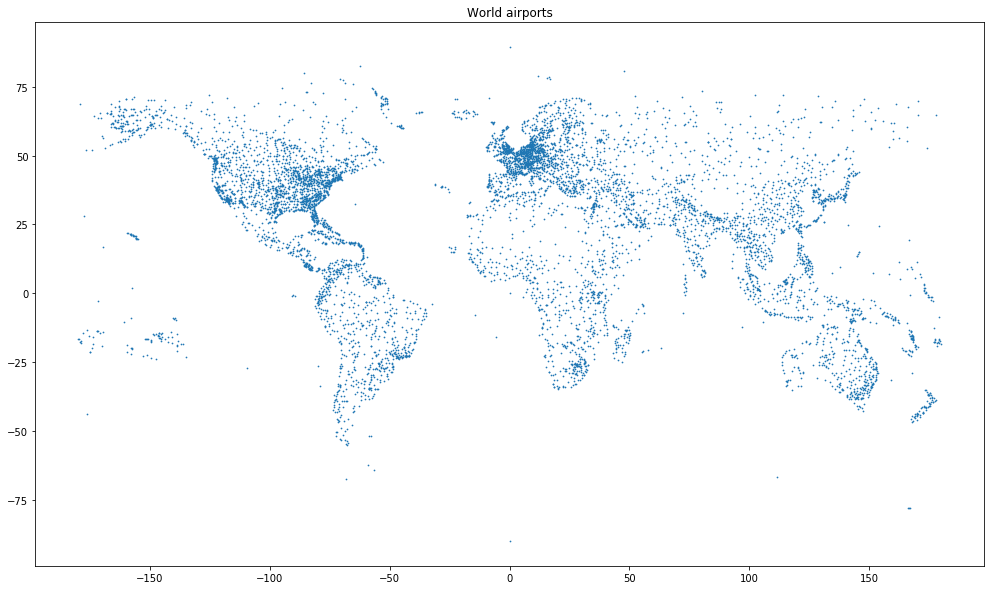

In [5]:
plt.figure(figsize=(17, 10))
plt.title("World airports")
plt.scatter(airport_df.Long, airport_df.Lat, s=0.5)
plt.show()

In [27]:
graph = nx.from_pandas_edgelist(connections_number, source = 'Source Airport', target = 'Dest Airport',
                       edge_attr = 'counts',create_using = nx.DiGraph())

In [51]:
routes_number.head(2)

,Source Airport,Dest Airport,counts
0,AAE,ALG,1
1,AAE,CDG,1


In [21]:
routes_subset = routes_number[routes_number.counts>5]
routes_subset.shape

(860, 3)

In [22]:
routes_subset = pd.merge(
    routes_subset, airport_df[['IATA', 'Lat', 'Long']], left_on='Source Airport', right_on='IATA')


routes_subset = pd.merge(
    routes_subset, airport_df[['IATA', 'Lat', 'Long']], left_on='Dest Airport', right_on='IATA')

In [24]:
routes_subset.drop(['IATA_x', 'IATA_y'], axis=1, inplace=True)
routes_subset.head(2)

,Source Airport,Dest Airport,counts,Lat_x,Long_x,Lat_y,Long_y
0,ABJ,ACC,7,5.26139,-3.92629,5.60519,-0.166786
1,ABJ,OUA,7,5.26139,-3.92629,12.35320,-1.512420


In [25]:
routes_subset.shape

(856, 7)

In [26]:
routes_subset.columns = ["source", "dest", "counts", "start_lat", "start_lon", "end_lat", "end_lon"]

In [27]:
airport_df_subset = airport_df[airport_df.IATA.isin(list(routes_subset.source) + list(routes_subset.dest))]

In [28]:

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon = airport_df_subset['Long'],
    lat = airport_df_subset['Lat'],
    hoverinfo = 'text',
    text = airport_df_subset['IATA'],
    mode = 'markers',
    
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

flight_paths = []
for i in range(len(routes_subset)):
    fig.add_trace(
        go.Scattergeo(
            lon = [routes_subset['start_lon'][i], routes_subset['end_lon'][i]],
            lat = [routes_subset['start_lat'][i], routes_subset['end_lat'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'red'),
            opacity = float(routes_subset['counts'][i]) / float(routes_subset['counts'].max()*2),
            
        )
    )

fig.update_layout(
    title_text = 'World Airport connections',
    showlegend = False,
    geo = dict(
        #scope = 'north america',
        #projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()

In [13]:
airport_info = pd.read_csv("data/airport_info.csv", index_col=0)
routes = pd.read_csv("data/routes.csv", index_col=0)

In [14]:
airport_info.head()

,link,code,name,city_country
0,/flights-from-anaa-aaa,AAA,Anaa Airport,"Anaa, French Polynesia"
1,/flights-from-annaba-aae,AAE,Rabah Bitat Airport (Les Salines,"Annaba, Algeria"
2,/flights-from-aranuka-aak,AAK,Aranuka Airport,"Aranuka, Kiribati"
3,/flights-from-aalborg-aal,AAL,Aalborg Airport,"Aalborg, Denmark"
4,/flights-from-al-ain-aan,AAN,Al Ain International Airport,"Al Ain, United Arab Emirates"


In [17]:
routes_subset = routes[routes.destination_flights>0]

In [18]:
print(routes_subset.shape)
routes_subset.head(2)

(25427, 3)


,course_code,destination_code,destination_flights
0,AAA,PPT,6
4,AAK,TRW,12


In [161]:
routes_subset.course_code.unique()

array(['ABV', 'ACE', 'ADB', 'ADL', 'AKL', 'AMD', 'AMS', 'ANF', 'AQP',
       'ARN', 'ATL', 'AYT', 'BAQ', 'BCN', 'BGA', 'BGO', 'BKI', 'BKK',
       'BLR', 'BNE', 'BOG', 'BOM', 'BON', 'BOS', 'BPN', 'BSB', 'BZE',
       'CAI', 'CAN', 'CBR', 'CCU', 'CEB', 'CGH', 'CGK', 'CGP', 'CHC',
       'CJC', 'CJJ', 'CJU', 'CKG', 'CLO', 'CNF', 'CNX', 'CPT', 'CTG',
       'CTS', 'CTU', 'CUN', 'CUR', 'CUZ', 'DAC', 'DAD', 'DAL', 'DAR',
       'DCA', 'DEL', 'DEN', 'DFW', 'DGA', 'DLC', 'DMK', 'DMM', 'DOH',
       'DPS', 'DTW', 'DUB', 'DUR', 'DUS', 'DVO', 'DXB', 'EIS', 'ESB',
       'EWR', 'FLL', 'FRA', 'FUK', 'GDL', 'GEG', 'GMP', 'GOI', 'GRU',
       'GYE', 'HAM', 'HAN', 'HDY', 'HGH', 'HIJ', 'HKG', 'HKT', 'HND',
       'HNL', 'HOU', 'HYD', 'ICN', 'ISG', 'IST', 'ITM', 'JED', 'JFK',
       'JHG', 'JHM', 'JNB', 'JOG', 'KCH', 'KHG', 'KIX', 'KKJ', 'KMG',
       'KMI', 'KMJ', 'KNO', 'KOA', 'KOJ', 'KTM', 'KUL', 'KWI', 'LAS',
       'LAX', 'LED', 'LGA', 'LGK', 'LHR', 'LIH', 'LIM', 'LKO', 'LOS',
       'LPA', 'MAA',

In [162]:
routes

,course_code,destination_code,destination_flights
0,AAA,PPT,6
1,AAA,MKP,0
2,AAA,RRR,0
3,AAA,FAC,0
4,AAK,TRW,12
...,...,...,...
28325,ZYL,JED,0
28326,ZYL,LHR,0
28327,ZYL,MCT,0
28328,ZZU,LIX,17


In [19]:
routes_subset = pd.merge(
    routes_subset, airport_df[['IATA', 'Lat', 'Long']], left_on='course_code', right_on='IATA')

routes_subset = pd.merge(
    routes_subset, airport_df[['IATA', 'Lat', 'Long']], left_on='destination_code', right_on='IATA')

In [20]:
routes_subset.drop(['IATA_x', 'IATA_y'], axis=1, inplace=True)
routes_subset.columns = ["source", "dest", "counts", "start_lat", "start_lon", "end_lat", "end_lon"]

In [21]:
airport_df_subset = airport_df[airport_df.IATA.isin(list(routes_subset.source) + list(routes_subset.dest))]

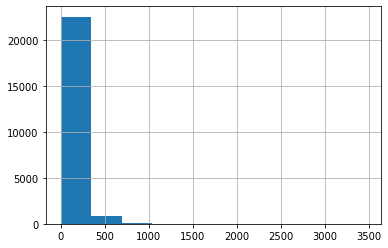

In [22]:
routes_subset.counts.hist()

In [23]:
routes_subset.head()

,source,dest,counts,start_lat,start_lon,end_lat,end_lon
0,AAA,PPT,6,-17.352600,-145.509995,-17.553699,-149.606995
1,AHE,PPT,4,-14.428100,-146.257004,-17.553699,-149.606995
2,APK,PPT,4,-15.573600,-146.414993,-17.553699,-149.606995
3,AUQ,PPT,14,-9.768790,-139.011002,-17.553699,-149.606995
4,BOB,PPT,171,-16.444401,-151.751007,-17.553699,-149.606995


In [24]:
routes_subset.shape, airport_df_subset.shape

((23564, 7), (3577, 13))

In [182]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon = airport_df_subset['Long'],
    lat = airport_df_subset['Lat'],
    hoverinfo = 'text',
    text = airport_df_subset['IATA'],
    mode = 'markers',
    
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

flight_paths = []
for i in range(len(routes_subset)):
    fig.add_trace(
        go.Scattergeo(
            lon = [routes_subset['start_lon'][i], routes_subset['end_lon'][i]],
            lat = [routes_subset['start_lat'][i], routes_subset['end_lat'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'red'),
            opacity = float(routes_subset['counts'][i]) / float(routes_subset['counts'].max()),
            
        )
    )

fig.update_layout(
    title_text = 'World Airport connections',
    showlegend = False,
    geo = dict(
        #scope = 'north america',
        # 'natural earth',
        projection_type = 'natural earth',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

# ['equirectangular', 'mercator', 'orthographic', 'natural
#             earth', 'kavrayskiy7', 'miller', 'robinson', 'eckert4',
#             'azimuthal equal area', 'azimuthal equidistant', 'conic
#             equal area', 'conic conformal', 'conic equidistant',
#             'gnomonic', 'stereographic', 'mollweide', 'hammer',
#             'transverse mercator', 'albers usa', 'winkel tripel',
#             'aitoff', 'sinusoidal']

fig.show()

In [25]:
routes_subset.rename(columns={"course_code":"source_code"}, inplace=True)# 

In [26]:
routes_subset.head()

,source,dest,counts,start_lat,start_lon,end_lat,end_lon
0,AAA,PPT,6,-17.352600,-145.509995,-17.553699,-149.606995
1,AHE,PPT,4,-14.428100,-146.257004,-17.553699,-149.606995
2,APK,PPT,4,-15.573600,-146.414993,-17.553699,-149.606995
3,AUQ,PPT,14,-9.768790,-139.011002,-17.553699,-149.606995
4,BOB,PPT,171,-16.444401,-151.751007,-17.553699,-149.606995


In [29]:
routes_subset = routes_subset[routes_subset.source.isin(airport_df.IATA)]
routes_subset = routes_subset[routes_subset.source.isin(airport_df.IATA)]

In [30]:
routes_subset.shape

(23564, 7)

In [32]:
graph = nx.from_pandas_edgelist(routes_subset, source = 'source', target = 'dest',
                       edge_attr = 'counts',create_using = nx.DiGraph())

In [33]:
from tqdm import tqdm_notebook

In [35]:
airport_df[airport_df.IATA=='AAA']

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
1973,Anaa Airport,Anaa,French Polynesia,AAA,NTGA,-17.3526,-145.509995,10,-10,U,Pacific/Tahiti,airport,OurAirports


In [36]:
xycoords = {}

for node in tqdm_notebook(list(graph.nodes)):
    xycoords[str(node)] = (
        airport_df.Long[airport_df.IATA ==node].values[0], 
        airport_df.Lat[airport_df.IATA == node].values[0]
    )

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



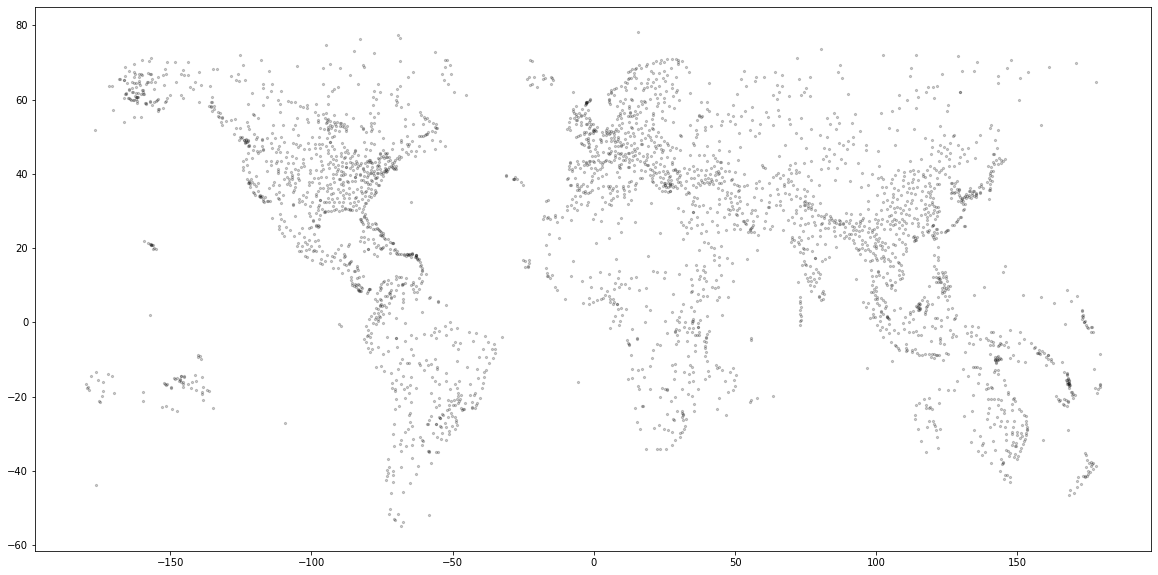

In [37]:
plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(graph,
                     pos=xycoords,
                     with_labels=False,
                     node_color='k',
                     node_size=5,
                     alpha=0.2)

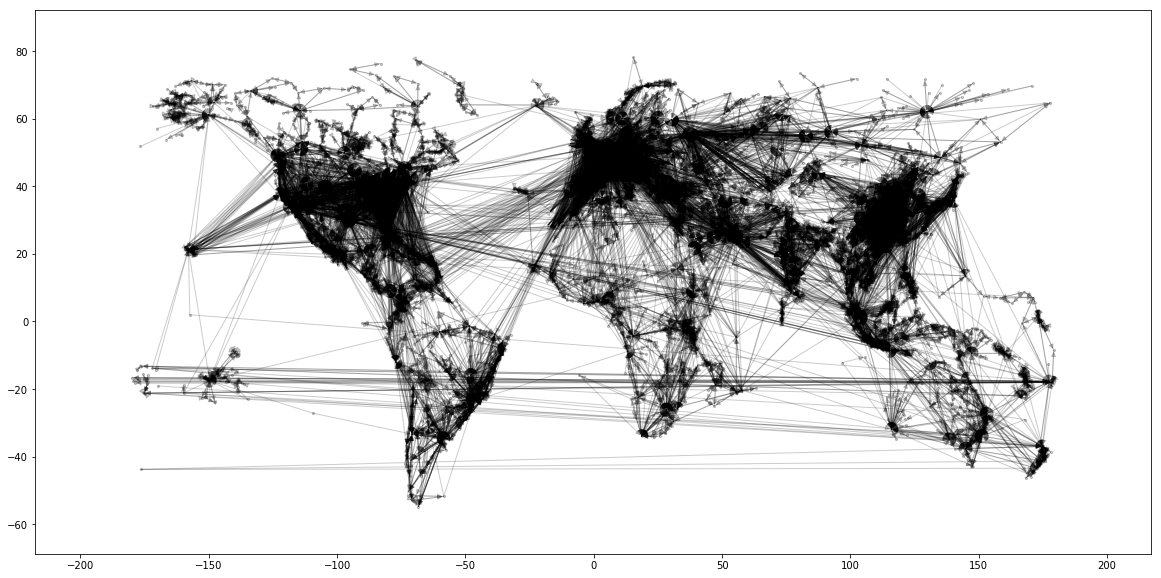

In [47]:
plt.figure(figsize=(20, 10))
nx.draw_networkx(graph,
                 pos=xycoords,
                 with_labels=False,
                 node_color='k',
                 node_size=5,
                 alpha=0.2)

In [38]:
routes[routes.destination_flights==0]

,course_code,destination_code,destination_flights
1,AAA,MKP,0
2,AAA,RRR,0
3,AAA,FAC,0
5,AAK,KUC,0
14,AAL,FAE,0
...,...,...,...
28323,ZYL,AUH,0
28324,ZYL,DOH,0
28325,ZYL,JED,0
28326,ZYL,LHR,0


In [39]:
population = pd.read_csv("data/city_population.csv", index_col=0)
population.head()

,Rank,Name,2020 Population,2019 Population,Change
0,1,Tokyo,37393129,37435191,-0.11%
1,2,Delhi,30290936,29399141,3.03%
2,3,Shanghai,27058479,26317104,2.82%
3,4,Sao Paulo,22043028,21846507,0.90%
4,5,Mexico City,21782378,21671908,0.51%


In [40]:
airport_df_subset = pd.merge(
    airport_df, population[['Name', '2020 Population']], how='inner', left_on='City', right_on='Name')

In [42]:
airport_df.shape, airport_df_subset.shape

((7698, 13), (1306, 15))

In [44]:
routes_subset = routes_subset[routes_subset.source.isin(airport_df_subset.IATA)]
routes_subset = routes_subset[routes_subset.dest.isin(airport_df_subset.IATA)]

In [45]:
routes_subset.shape

(7853, 7)

In [46]:
graph = nx.from_pandas_edgelist(routes_subset, source = 'source', target = 'dest',
                       edge_attr = 'counts',create_using = nx.DiGraph())

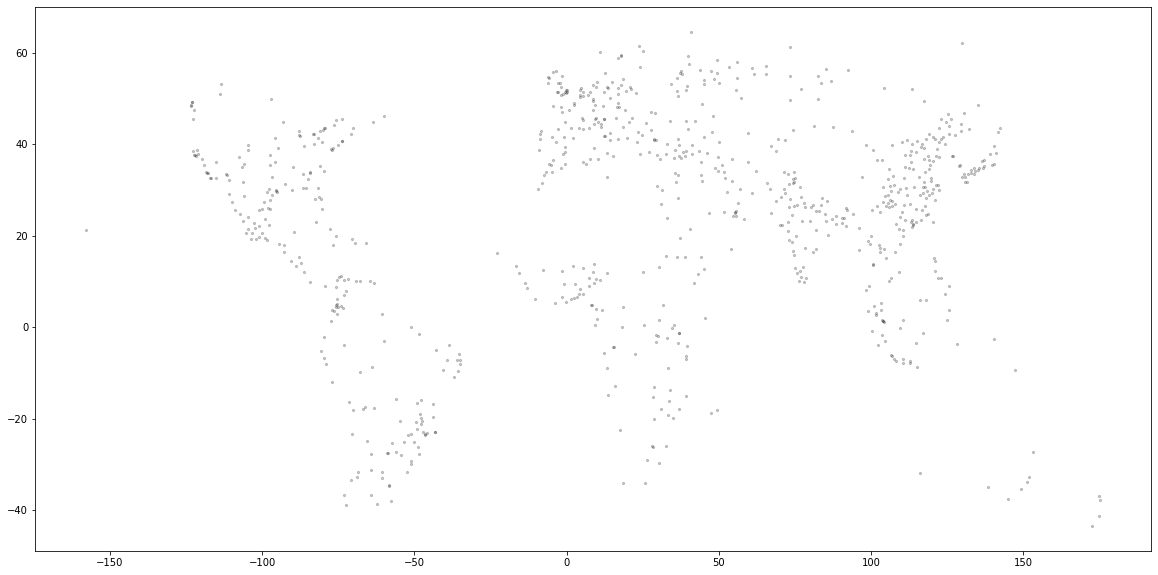

In [47]:
plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(graph,
                     pos=xycoords,
                     with_labels=False,
                     node_color='k',
                     node_size=5,
                     alpha=0.2)

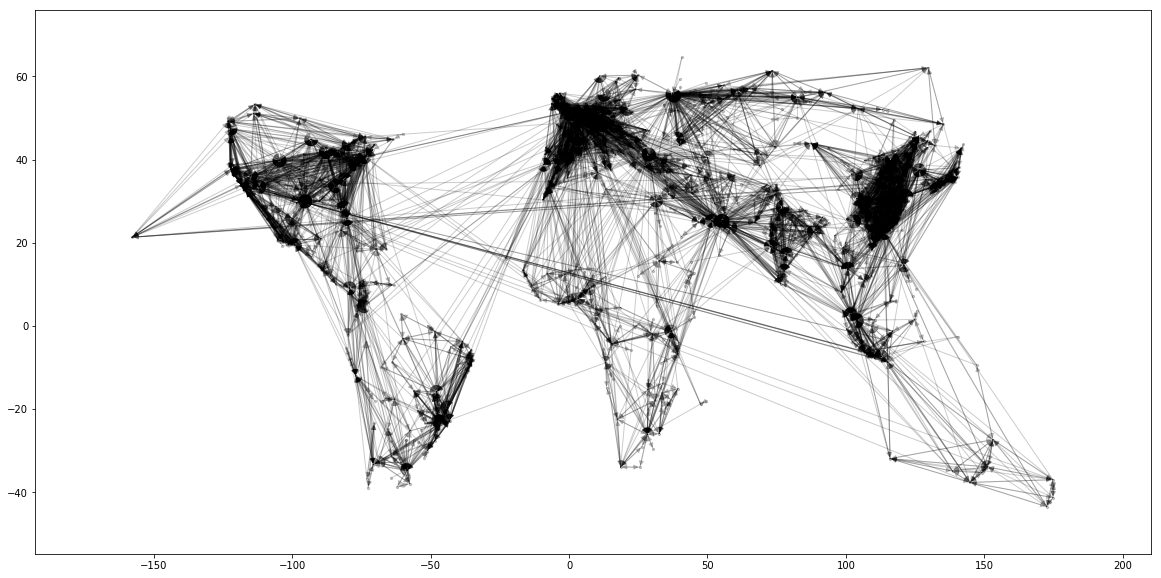

In [90]:
plt.figure(figsize=(20, 10))
nx.draw_networkx(graph,
                 pos=xycoords,
                 with_labels=False,
                 node_color='k',
                 node_size=5,
                 alpha=0.2)

## Network infection spread

--- 

Infection of airports

P(plane infected) = I/N, I - # infected in the city, N - population of the city

P(new city infected) = 1 - P(all incoming places are healthy) = 

= P(all planes from city A are healthy) * P(all planes from city B are healthy) ...

= 1 - [(1 - I_A/N_A) ^ f_A * (1 - I_B/N_B) ^ f_B]


f - flights per day



In [208]:
def prob_infected_plane(I, N):
    """
    I - number of infected in the city
    N - total population in the city
    """
    return I/N


def prob_city_infected(infectious_sources, populations_sources, daily_flights_sources):
    """
    Calculates the probability that the city will be infected by any of the incoming planes
    
    
    Formula used:
    P(new city infected) = 1 - P(all incoming places are healthy) = \
        = P(all planes from city A are healthy) * P(all planes from city B are healthy) * ...
        = 1 - [(1 - I_A/N_A) ^ f_A * (1 - I_B/N_B) ^ f_B * ...]
        
    """
    prob_all_planes_healthy = 1
    for I, N, f in zip(infectious_sources, populations_sources, daily_flights_sources):    
        prob_all_planes_healthy *= (1-prob_infected_plane(I, N)) ** f
        
    return 1 - prob_all_planes_healthy

In [196]:
1 - (1-(1/10))**10 * (1-(1/2))**4

0.97820759749375

In [272]:
prob_city_infected([5000], [14000000], [500])

0.1635623716029293

In [152]:
1 - 0.5**10

0.9990234375

## City infection spread (SIR)

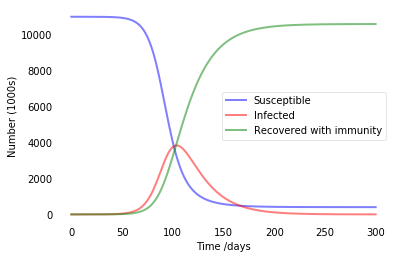

In [269]:
from scipy.integrate import odeint

# Total population, N.
N = 11000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 100, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 2.4/14, 1./20
# A grid of time points (in days)
t = np.linspace(0, 300, 300)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [232]:
airport_df_subset[airport_df_subset.IATA=='WUH']

,Name_x,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source,Name_y,2020 Population
877,Wuhan Tianhe International Airport,Wuhan,China,WUH,ZHHH,30.7838,114.208,113,8,U,Asia/Shanghai,airport,OurAirports,Wuhan,8364977


In [241]:
prob_city_infected([5000], [8364977], [197])

0.11111558640092278

In [235]:
routes_subset[routes_subset.source=='WUH']

,source,dest,counts,start_lat,start_lon,end_lat,end_lon
7427,WUH,CTU,197,30.7838,114.208,30.578501,103.946999
7605,WUH,CKG,177,30.7838,114.208,29.719200,106.641998
7827,WUH,KMG,161,30.7838,114.208,25.101944,102.929167
7935,WUH,SZX,141,30.7838,114.208,22.639299,113.810997
8068,WUH,CAN,190,30.7838,114.208,23.392401,113.299004
8316,WUH,PVG,144,30.7838,114.208,31.143400,121.805000
8367,WUH,SYX,102,30.7838,114.208,18.302900,109.412003
9785,WUH,NNG,53,30.7838,114.208,22.608299,108.171997
9857,WUH,HAK,116,30.7838,114.208,19.934900,110.459000
9948,WUH,HGH,60,30.7838,114.208,30.229500,120.433998


In [68]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

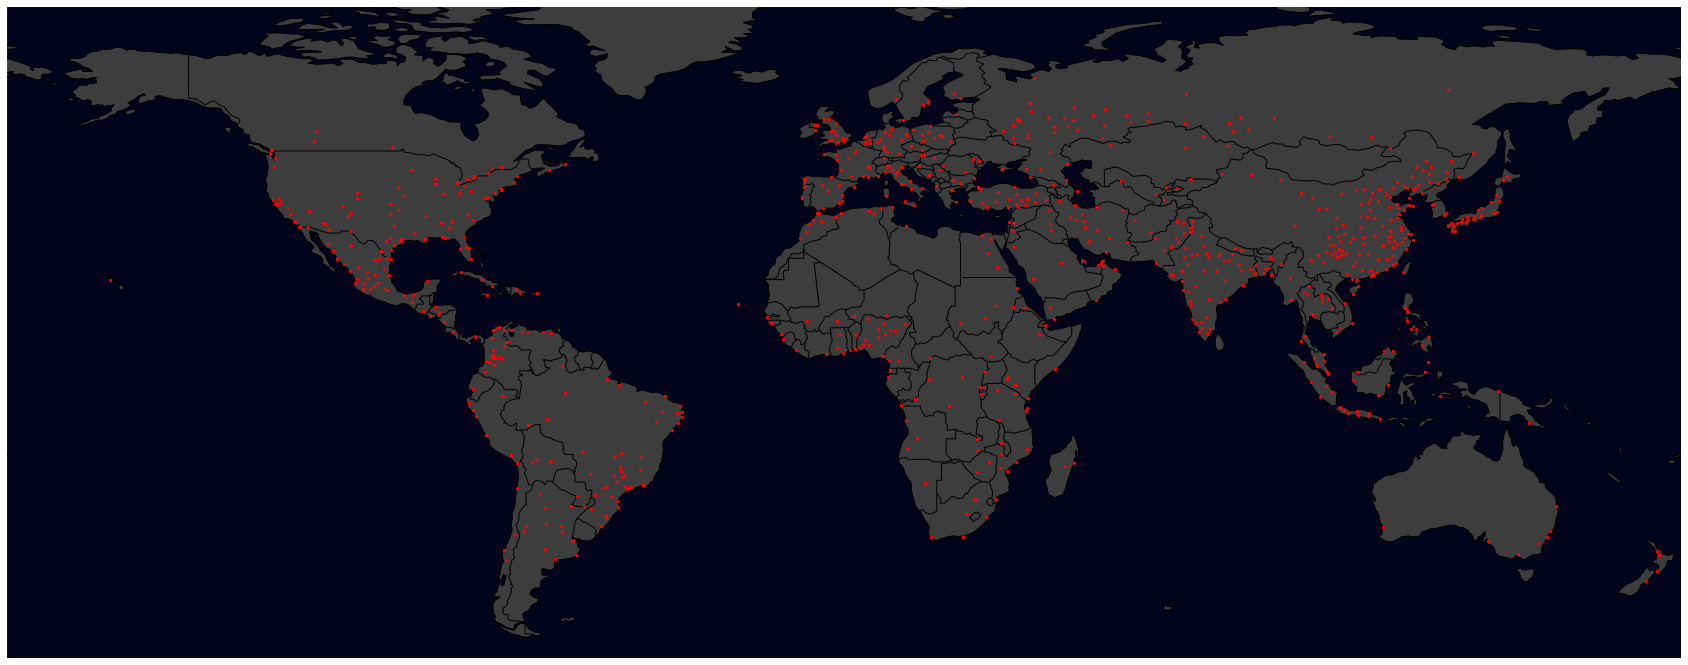

In [273]:
plt.figure(figsize=(30, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.LAND, color='#3d3d3d')
ax.add_feature(cfeature.OCEAN, color='#04031c')
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.outline_patch.set_visible(False)

nx.draw_networkx_nodes(graph,
                     pos=xycoords,
                     with_labels=False,
                     node_color='r',
                     node_size=5,
                     alpha=1)

plt.xlim(-180, 180)
plt.ylim(-60, 80) 
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



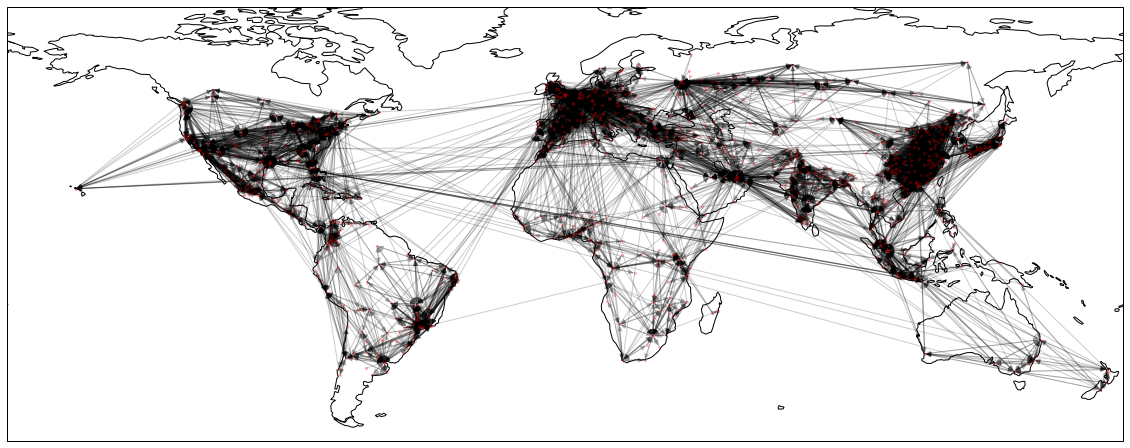

In [66]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# nx.draw_networkx_nodes(graph,
#                      pos=xycoords,
#                      with_labels=False,
#                      node_color='r',
#                      node_size=5,
#                      alpha=1)

nx.draw_networkx(graph,
                 pos=xycoords,
                 with_labels=False,
                 node_color='r',
                 node_size=5,
                 alpha=0.2)

plt.xlim(-180, 180)
plt.ylim(-60, 80)
plt.show()

In [144]:
# im = plt.imread("Mercator_Blank_Map_World.png")

# plt.figure(figsize=(15, 7))

# implot = plt.imshow(im, extent=[-140,140,-90, 90])

# nx.draw_networkx_nodes(graph,
#                      pos=xycoords,
#                      with_labels=False,
#                      node_color='r',
#                      node_size=5,
#                      alpha=0.2)